In [227]:
import pandas as pd
import numpy as np
import re
import spacy
import html
import emoji
import unidecode
import subprocess
import sys
from collections import Counter
import matplotlib.pyplot as plt
from typing import List

from spacy.lang.pt.stop_words import STOP_WORDS as SPACY_STOP
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [135]:
train_df = pd.read_csv('./train_movies.csv')
test_df = pd.read_csv('./test_movies.csv')

In [136]:
train_df.shape

(40588, 4)

## **Análise Exploratória**

In [137]:
# Top tokens no dataset de treino
nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser", "tagger"])

RE_WORD = re.compile(r"^[A-Za-zÀ-ÖØ-öø-ÿ]+$|^<\w+>$")

def top_tokens_words(text_series, top_n=100):
    total = Counter()
    for doc in nlp.pipe(text_series, batch_size=1000):
        total.update(
            tok.text.lower()
            for tok in doc
            if (not tok.is_space)
            and RE_WORD.match(tok.text)
        )
    return total.most_common(top_n)

top100_words = top_tokens_words(train_df["text"], 100)

print('Top 100 tokens no dataset de treino (15 primeiros):')
for i, (token, count) in enumerate(top100_words[:15]):
    print(f"{i+1:>2d}. {token:<15} {count:>5d}")

# Contagem de stop-words dentro desse top100
stop_words = set(SPACY_STOP)

def count_stop_words(tokens):
    return sum(1 for t in tokens if t in stop_words)

stop_count = count_stop_words([t for t, _ in top100_words])
print(f"Stop-words no top100 (sem pontuação): {stop_count}/{len(top100_words)} "
      f"({stop_count/len(top100_words):.2%})")

# Quais tokens de conteúdo (não-stop-word) sobraram?
not_stop = [t for t, _ in top100_words if t not in stop_words]
print()
print(f'Tokens do top100 que não estão na lista de stop-words: {not_stop}' )

Top 100 tokens no dataset de treino (15 primeiros):
 1. que             43917
 2. o               42717
 3. de              40822
 4. e               39099
 5. a               35031
 6. filme           30041
 7. é               25962
 8. um              21998
 9. não             21185
10. do              19445
11. uma             14055
12. mas             13716
13. com             13274
14. muito           11604
15. da              11443
Stop-words no top100 (sem pontuação): 81/100 (81.00%)

Tokens do top100 que não estão na lista de stop-words: ['filme', 'pra', 'história', 'melhor', 'filmes', 'achei', 'gostei', 'roteiro', 'cenas', 'personagens', 'assistir', 'cena', 'vida', 'personagem', 'acho', 'cinema', 'vi', 'trilha', 'atuação']


In [275]:
# verificar em qual posição as palavras de not_stop ocupam no top100
not_stop_positions = [(i+1, t) for i, (t, _) in enumerate(top100_words) if t in not_stop]
print(f'Posições das palavras de not_stop no top100: {not_stop_positions}')  

Posições das palavras de not_stop no top100: [(6, 'filme'), (28, 'pra'), (38, 'história'), (42, 'melhor'), (44, 'filmes'), (47, 'achei'), (55, 'gostei'), (57, 'roteiro'), (61, 'cenas'), (67, 'personagens'), (69, 'assistir'), (77, 'cena'), (80, 'vida'), (81, 'personagem'), (82, 'acho'), (88, 'cinema'), (89, 'vi'), (93, 'trilha'), (98, 'atuação')]


# **Pré Processamento**

In [138]:
# NORMALIZAÇÃO
# Padronizar texto deixando as palavras em letras minúsculas e trocando padrões volumosos por placeholders. 
# Isso reduz esparsidade e mantém sinal útil (números, intensidade “!!!”, “???”)

RE_URL   = re.compile(r"(http\S+|www\.\S+)")
RE_HTML  = re.compile(r"<[^>]+>")
RE_NUM   = re.compile(r"(\d+[.,]?\d*|\d+/\d+)")
RE_EXCL  = re.compile(r"!{2,}")
RE_QST   = re.compile(r"\?{2,}")
RE_PUNCT = re.compile(r"[^\wÀ-ÿ\s<>]")
RE_SPACE = re.compile(r"\s{2,}")

def clean(text: str, strip_accents: bool = True) -> str:
    text = html.unescape(text or "")
    # --- placeholders que preservam sinal sentiment (NUM, EXCL, QST) ----------
    text = RE_NUM.sub(" <NUM> ", text)
    text = RE_EXCL.sub(" <EXCL> ", text)
    text = RE_QST.sub(" <QST> ", text)
    # --- remoção de ruído estrutural ------------------------------------------
    text = RE_URL.sub(" ", text)
    text = RE_HTML.sub(" ", text)
    # --- lower / remoção de acento p/ padronizar vocab ------------------------
    text = text.lower()
    if strip_accents:
        text = unidecode.unidecode(text)
    # --- limpeza final de pontuação residual e múltiplos espaços -------------
    text = RE_PUNCT.sub(" ", text)
    text = RE_SPACE.sub(" ", text).strip()
    return text

In [139]:
# EMOJIS
# Emojis são fortes pistas de polaridade. Usamos emoji.demojize para convertê-los em short-codes “:nome:”, 
# depois viram tokens únicos do tipo <EMOJI_nome>. Preservando emoção sem explodir o vocabulário

RE_DEMOJ = re.compile(r":([a-z0-9_&+\-]+):")

def replace_emojis(text: str) -> str:
    text = emoji.demojize(text, language="en")
    return RE_DEMOJ.sub(lambda m: f" <EMOJI_{m.group(1)}> ", text)

In [140]:
# STOP WORDS
# Começamos com a lista oficial do spaCy
# Depois removemos palavras que carregam polaridade (“não”, “jamais” etc.) e
# adicionamos os termos ultra-frequentes do domínio (ex.: “filme”, “história”) para evitar que dominem o TF-IDF.  

stop_words = set(SPACY_STOP)

stop_words -= {"não", "nunca", "jamais", "sem", "nem"}

domain_neutral = set(not_stop)

stop_words |= domain_neutral

In [141]:
# TOKENIZAÇÃO + LEMATIZAÇÃO
# Carregamos o modelo leve pt_core_news_sm e marcamos no vocab os stop-wordsvfinais
# Tokenizamos cada frase, descartando stop-words e retornando lemas
# para reduzir sparsidade (ex.: “assistindo” → “assistir”)

try:
    nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "pt_core_news_sm"])
    nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser"])

for w in stop_words:
    nlp.vocab[w].is_stop = True

def tokenize_spacy(text: str) -> List[str]:
    # ordem: emojis → limpeza → spaCy
    text = replace_emojis(text)
    text = clean(text)
    doc = nlp(text)
    return [tok.lemma_ for tok in doc if not tok.is_stop and tok.text.strip()]

In [142]:
# VETORIZAÇÃO TF-IDF
# Convertemos tokens em vetores esparsos TF-IDF com uni-/bi-gramas

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenize_spacy,
    preprocessor=lambda x: x, # já pre-processado na tokenização
    lowercase=False, # texto já em lower
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    norm="l2",
)

# **Treino e teste**

In [143]:
# Aplicar o vetorizador nos dados de treino e teste
X_train = tfidf_vectorizer.fit_transform(train_df["text"])
X_test = tfidf_vectorizer.transform(test_df["text"])

c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
y_train = train_df["discrete_stars"].astype(int).values
y_test = test_df["discrete_stars"].astype(int).values

In [234]:
def train_and_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
    
    report = classification_report(y_test, y_hat, digits=3, zero_division=0, output_dict=True)
    print(classification_report(y_test, y_hat, digits=3, zero_division=0))
    
    # Calcular AUC
    # Checa se o modelo tem o método predict_proba antes de calcular o AUC
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    else:
        auc = None
    
    report['auc'] = auc

    return report, y_hat

In [235]:
knn_report, knn_preds = train_and_test(
    KNeighborsClassifier(n_neighbors=5), 
    X_train, y_train, X_test, y_test
)

              precision    recall  f1-score   support

           1      0.213     0.487     0.296      1929
           2      0.272     0.202     0.232      1818
           3      0.246     0.125     0.166      1865
           4      0.203     0.117     0.149      1839
           5      0.278     0.232     0.252      1961

    accuracy                          0.235      9412
   macro avg      0.242     0.233     0.219      9412
weighted avg      0.242     0.235     0.220      9412



In [236]:
svm_report, svm_preds = train_and_test(
    LinearSVC(max_iter=1000, class_weight="balanced"),
    X_train, y_train, X_test, y_test
)

              precision    recall  f1-score   support

           1      0.312     0.304     0.308      1929
           2      0.431     0.474     0.451      1818
           3      0.318     0.293     0.305      1865
           4      0.302     0.279     0.290      1839
           5      0.408     0.442     0.424      1961

    accuracy                          0.358      9412
   macro avg      0.354     0.358     0.356      9412
weighted avg      0.354     0.358     0.356      9412



In [237]:
nb_report, nb_preds = train_and_test(
    MultinomialNB(),
    X_train, y_train, X_test, y_test
)

              precision    recall  f1-score   support

           1      0.361     0.187     0.246      1929
           2      0.407     0.552     0.469      1818
           3      0.342     0.330     0.336      1865
           4      0.311     0.326     0.318      1839
           5      0.435     0.491     0.461      1961

    accuracy                          0.376      9412
   macro avg      0.371     0.377     0.366      9412
weighted avg      0.372     0.376     0.366      9412



In [238]:
logreg_report, logreg_preds = train_and_test(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    X_train, y_train, X_test, y_test
)

              precision    recall  f1-score   support

           1      0.323     0.313     0.318      1929
           2      0.470     0.502     0.486      1818
           3      0.349     0.312     0.329      1865
           4      0.313     0.288     0.300      1839
           5      0.435     0.497     0.464      1961

    accuracy                          0.383      9412
   macro avg      0.378     0.382     0.379      9412
weighted avg      0.378     0.383     0.380      9412



In [239]:
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_reports(reports, model_names):
    assert len(reports) == len(model_names), "A lista de reports deve ter o mesmo tamanho da lista de nomes."

    # Extrai as métricas de cada report
    accuracies = [report['accuracy'] for report in reports]
    recalls    = [report['macro avg']['recall'] for report in reports]
    precisions = [report['macro avg']['precision'] for report in reports]
    f1_scores  = [report['macro avg']['f1-score'] for report in reports]
    aucs       = [report.get('auc', 0) if report.get('auc', 0) is not None else 0 for report in reports]

    x = np.arange(len(model_names))  # Posições dos grupos no eixo X
    width = 0.15  # Largura de cada barra (menor para caberem 5)

    offsets = [-2, -1, 0, 1, 2]  # 5 métricas, centralizadas
    bars = []

    fig, ax = plt.subplots(figsize=(14, 6))
    bars.append(ax.bar(x + offsets[0]*width, accuracies, width, label='Acurácia', color='red'))
    bars.append(ax.bar(x + offsets[1]*width, recalls,    width, label='Recall',   color='green'))
    bars.append(ax.bar(x + offsets[2]*width, precisions, width, label='Precisão', color='gold'))
    bars.append(ax.bar(x + offsets[3]*width, f1_scores,  width, label='F1-Score', color='blue'))
    bars.append(ax.bar(x + offsets[4]*width, aucs,       width, label='AUC',      color='purple'))

    # Adiciona os valores em cima das barras
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Modelos')
    ax.set_ylabel('Pontuação')
    ax.set_title('Comparação de Métricas de Classificação')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 0.8)
    ax.legend()
    ax.grid(True, linestyle='--', axis='y', alpha=0.6)

    plt.tight_layout()
    plt.show()

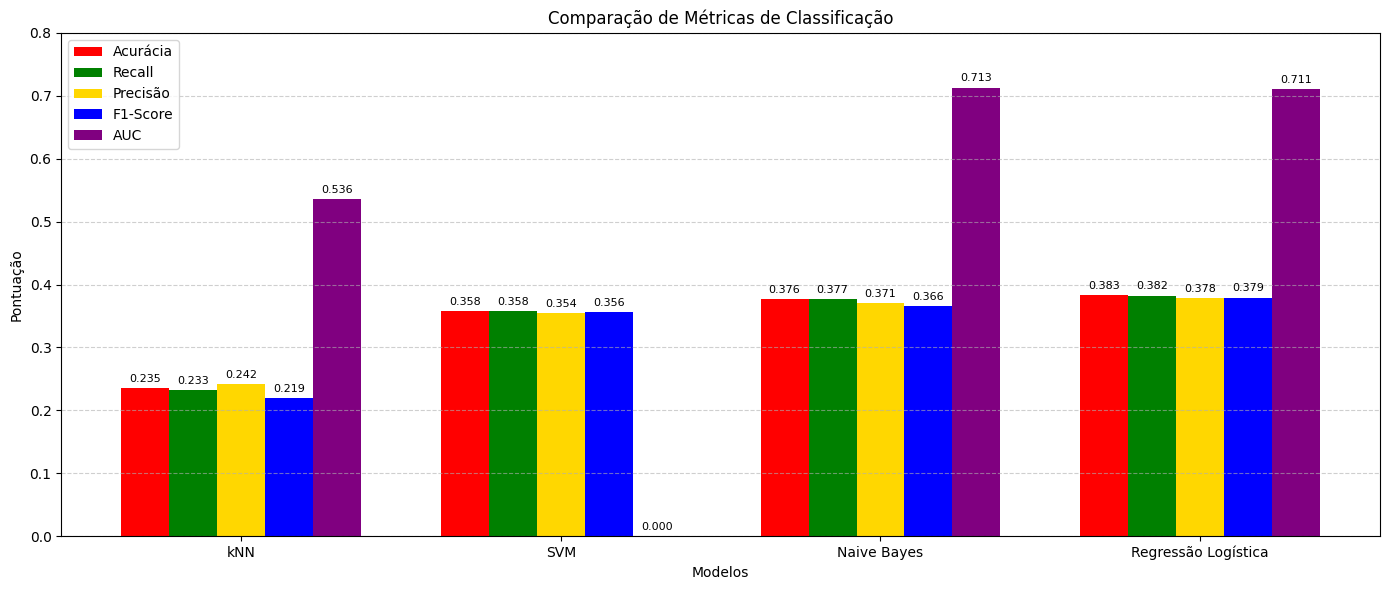

In [240]:
plot_classification_reports(
    reports=[knn_report, svm_report, nb_report, logreg_report],
    model_names=['kNN', 'SVM', 'Naive Bayes', 'Regressão Logística']
)

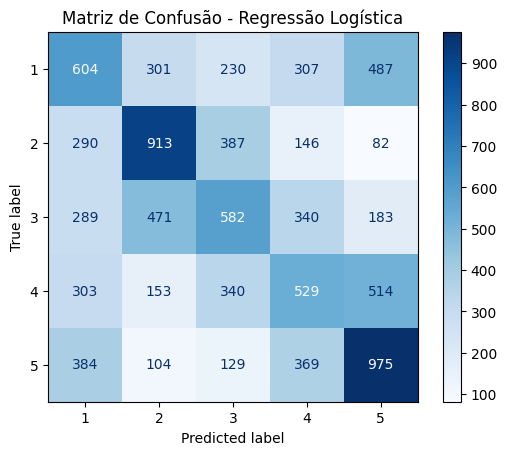

In [272]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plotar
def plot_confusion_matrix(y_true, y_pred, classes, title='Matriz de Confusão'):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
# Plotar matriz de confusão para o modelo de Regressão Logística
plot_confusion_matrix(
    y_true=y_test,
    y_pred=logreg_preds,
    classes=np.unique(y_test),
    title='Matriz de Confusão - Regressão Logística'
)